In [20]:
from __future__ import division
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(1337)  # for reproducibility

from sklearn.datasets import make_swiss_roll

from theano import function
import matplotlib.patches as mpatches
from keras.datasets import mnist
from keras.models import Sequential
from numpy.random import normal
from keras.layers.core import Dense, Dropout, Activation, Flatten, Reshape, Layer
from keras.layers.convolutional import Convolution2D, MaxPooling2D, UpSampling2D
from keras.layers.normalization import BatchNormalization as BN
from keras.utils import np_utils
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras.regularizers import l2

from seya.layers.variational import VariationalDense as VAE
from seya.layers.convolutional import GlobalPooling2D
from seya.utils import apply_model
from seya.layers.regularization import ITLRegularizer
from seya.parzen import ParzenWindows

from agnez import grid2d, embedding2dplot
import math

In [2]:
# load mnist dataset and select four digital:'0','1','4','5'
img_rows, img_cols = 28, 28
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x4_train = x_train[np.where(y_train == 0)]
y4_train = y_train[np.where(y_train== 0)]
x4_test = x_test[np.where(y_test == 0)]
y4_test = y_test[np.where(y_test == 0)]
number=[1,4,5]
for i in number:
    x_temp_train = x_train[np.where(y_train == i)]
    y_temp_train = y_train[np.where(y_train == i)]
    x_temp_test = x_test[np.where(y_test == i)]
    y_temp_test = y_test[np.where(y_test == i)]
    x4_train = np.vstack((x4_train,x_temp_train))
    y4_train = np.hstack((y4_train,y_temp_train))
    x4_test = np.vstack((x4_test,x_temp_test))
    y4_test = np.hstack((y4_test,y_temp_test))

    
    
# shuffle data and split between train,validate and test sets
x4_train = x4_train.reshape(-1,784)
x4_test = x4_test.reshape(-1,784)
input_train = np.column_stack((x4_train,y4_train)) 
input_test = np.column_stack((x4_test,y4_test))
np.random.shuffle(input_train)
np.random.shuffle(input_test)
X_train = input_train[:,:784]
y_train = input_train[:,784]
X_test = input_test[:,:784]
y_test = input_test[:,784]
X_train = X_train.astype("float32")
X_test = X_test.astype("float32")
X_train /= 255
X_test /= 255

X_valid = X_train[20000:]
X_train = X_train[:20000]

print('X_train shape',X_train.shape)
print('X_valid shape',X_valid.shape)
print('X_test shape',X_test.shape)

X_train shape (20000, 784)
X_valid shape (3928, 784)
X_test shape (3989, 784)


In [8]:
#add mix_Gaussian source noise
noise_v1 = 1
noise_v2 = 10
A = .1
noise_factor = 0.01
source_noise_train = (1-A) * normal(0, np.sqrt(noise_v1), X_train.shape) 
                     + A * normal(0, np.sqrt(noise_v2), X_train.shape)
source_noise_valid= (1-A) * normal(0, np.sqrt(noise_v1), X_valid.shape) 
                     + A * normal(0, np.sqrt(noise_v2), X_valid.shape)
source_noise_test= (1-A) * normal(0, np.sqrt(noise_v1), X_test.shape) 
                     + A * normal(0, np.sqrt(noise_v2), X_test.shape)

x_train_noisy = X_train + noise_factor*source_noise_train
x_valid_noisy = X_valid + noise_factor*source_noise_valid
x_test_noisy = X_test + noise_factor*source_noise_test

In [4]:
# four Gaussian prior distribution
# size is the number of samples for each Gaussian
# scalar can change the distance between the Gaussian
mix_gaussian_scalar=2.
def gaussian_mixture_4(size, scalar=mix_gaussian_scalar):
    size = 400
    mean1 = [4.*scalar, 0.*scalar]
    mean2 = [0*scalar, 4*scalar]
    mean3 = [-4.*scalar, 0.*scalar]
    mean4 = [0.*scalar, -4.*scalar]

    cov1 = [[5., 0.], [0., 1.]]
    cov2 = [[1, 0], [0, 5]]
    cov3 = [[5., 0.], [0., 1.]]
    cov4 = [[1., 0.], [0., 5.]]

    X1 = np.random.multivariate_normal(mean1, cov1, size)
    X2 = np.random.multivariate_normal(mean2, cov2, size)
    X3 = np.random.multivariate_normal(mean3, cov3, size)
    X4 = np.random.multivariate_normal(mean4, cov4, size)

    X = K.concatenate([X1, X2, X3, X4], axis=0)
    return X

In [5]:
#add channel noise
def my_awgn(sig,SNR):
    sigPower= sum(sum(abs(sig)**2))/(sig.shape[0]*sig.shape[1])
    sigPower = 10*math.log10(sigPower)
    noisePower = sigPower - SNR
    p = 10**(noisePower/10)
    noise = (np.sqrt(p))*np.random.randn(sig.shape[0],sig.shape[1])
    noise_sig = sig + noise
    return noise_sig

In [9]:
#Principle of relevant information(pri)
pri_lambda = 5
pri_scale = 1
pri_ksize = 6.

# encoder architecture
enc = Sequential()
enc.add(Dense(1000, input_dim=784, activation='relu'))
enc.add(BN())
enc.add(Dense(1000, activation='relu'))
enc.add(BN())
enc.add(Dense(2))
enc.add(ITLRegularizer(distance='pri', scale=pri_scale, 
                       ksize=pri_ksize, pri_lambda=pri_lambda,
                       distribution=gaussian_mixture_4                      
                     ))
#decoder architecture
dec = Sequential()
dec.add(Dense(1000, input_dim=2, activation='relu'))
dec.add(Dense(784, activation='sigmoid'))

In [10]:
# complie model and use c-loss cost funciton and adam optimizer
closs_ksize = 4.0
model = Sequential(ksize = closs_ksize)
model.add(enc)
model.add(dec)
model.compile(loss='c_loss', optimizer='adam')
model.summary()

--------------------------------------------------------------------------------
Initial input shape: (None, 784)
--------------------------------------------------------------------------------
Layer (name)                  Output Shape                  Param #             
--------------------------------------------------------------------------------
Sequential (Unnamed)          (None, 2)                     1792002             
Sequential (Unnamed)          (None, 784)                   787784              
--------------------------------------------------------------------------------
Total params: 2579786
--------------------------------------------------------------------------------


In [ ]:
# train and save the best model
#cbk = ModelCheckpoint('./noise_Gaussian4_pri_model/c_loss_A_0.9.hdf5', 
#                      save_best_only=True, verbose=True)
#model.fit(x_train_noisy, X_train.reshape((-1, 784)), batch_size=800, 
#                       nb_epoch=100, verbose=2,
#                      validation_data=(x_valid_noisy, 
#                      X_valid.reshape((-1, 784))),
#                      callbacks=[cbk])

In [12]:
#load the best model
model.load_weights('./noise_Gaussian4_pri_model/c_loss_A_0.1.hdf5')

In [13]:
X = K.placeholder(ndim=2)
Y = dec(X)
F_dec = function([X], Y, allow_input_downcast=True)
X = K.placeholder(ndim=2)
Y = enc(X)
F_enc = function([X], Y, allow_input_downcast=True)

Text(0.5, 1.0, 'channel_noise = 14dB')

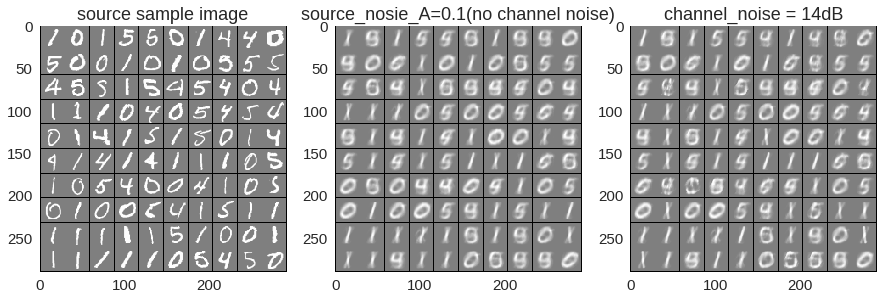

In [16]:
#use source noise as input
y = F_enc(x_train_noisy[:100])
#add channel noise
y_noisy = my_awgn(y,14)
y_dec = F_dec(y)#source 
y_noise_dec = F_dec(y_noisy)# add channel noise
plt.figure(figsize = (15,8))
#no channel noise
I_source_noise = grid2d(y_dec.reshape((100, -1)))
#channel noise
I_channel_noise = grid2d(y_noise_dec.reshape((100, -1)))
#source sample images
I = grid2d(X_train[:100].reshape((100, -1)))
plt.subplot(1,3,1)
plt.imshow(I, cmap='gray')
plt.title('source sample image')
plt.subplot(1,3,2)
plt.imshow(I_source_noise, cmap='gray')
plt.title('source_nosie_A=0.1(no channel noise)')
plt.subplot(1,3,3)
plt.imshow(I_channel_noise, cmap='gray')
plt.title('channel_noise = 14dB')

(-15, 15)

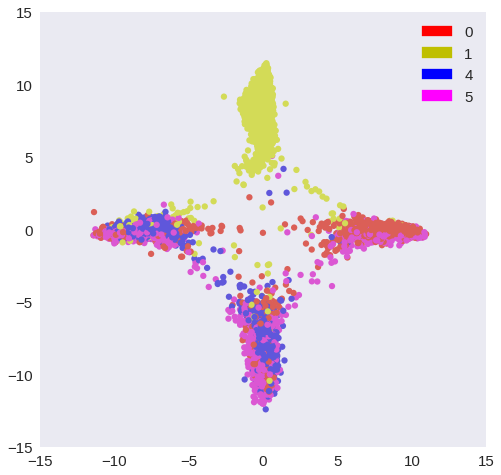

In [21]:
#Bottleneck layer codes visualization
y = F_enc(X_train[:6000])
_ = embedding2dplot(y, y_train[:6000], show_median=False)
five_patch = mpatches.Patch(color='magenta', label='5')
four_patch = mpatches.Patch(color='blue', label='4')
one_patch = mpatches.Patch(color='y', label='1')
zero_patch = mpatches.Patch(color='red', label='0')
plt.legend(handles=[zero_patch,one_patch,four_patch,five_patch])
plt.axis('on')
plt.xlim(-15, 15)
plt.ylim(-15, 15)